In [14]:
%pip install pandas
%pip install pgvector
%pip install sqlalchemy
%pip install sqlalchemy.orm
%pip install sentence_transformers

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Laboratory 2 homework

Homework is creating a multimodal similarity search service. It will retrieve images
based on a text query, using embeddings from a multimodal model.

### Dataset preparation (1 point)

1. Download the dataset: [Amazon Berkeley Objects Dataset](https://amazon-berkeley-objects.s3.amazonaws.com/archives/abo-images-small.tar)
2. Unpack the dataset and locate the metadata file `images.csv.gz` in `images/metadata/`
3. Extract the image paths from the dataset:
   - write a Python script that extracts valid image paths from the CSV file
   - keep only images with at least 1000 pixels of width and height
   - you can use Pandas, Polars etc. as you wish, add with `uv` whatever is necessary

In [1]:
import tarfile
import gzip
import pandas as pd

with tarfile.open("data/abo-images-small.tar", 'r') as tar:

    tar.extract("images/metadata/images.csv.gz", "data")
    with gzip.open("data/images/metadata/images.csv.gz", 'rb') as csv:
        df = pd.read_csv(csv)
        df = df[ ( df["height"] >= 100 ) & ( df["width"] >= 100 ) ]

        for index, image in df.iterrows():
            try:
                path = image["path"]
                tar.extract(f"images/small/{path}", "data")
            except:
                print(f"missing {path}")

/var/folders/5w/r6bm3z1940v7gw8tz4sfnjc40000gn/T/ipykernel_5641/2983297567.py:7: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extract("images/metadata/images.csv.gz", "data")
/var/folders/5w/r6bm3z1940v7gw8tz4sfnjc40000gn/T/ipykernel_5641/2983297567.py:15: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extract(f"images/small/{path}", "data")



### Model Selection and Understanding (1 point)

1. Read the [CLIP Image Search Tutorial](https://www.sbert.net/examples/applications/image-search/README.html).
2. Search for `clip-ViT-B-32` model from `sentence-transformers` on HuggingFace Hub.
3. Determine the vector length (size) produced by the model, and what type of model is it.

**Questions:**
- What is the vector size produced by `clip-ViT-B-32`? 
> 512

- What do `ViT`, `B` and `32` mean in the model name?
> ViT: Stands for "Vision Transformer," which is a type of neural network architecture designed for image processing tasks.
> B: Refers to the model size, specifically "Base." Other sizes might include "Small" (S) or "Large" (L).
> 32: Indicates the patch size, meaning the input image is divided into patches of 32x32 pixels before being processed by the Vision Transformer.



### Database setup (2 points)

1. Set up Postgres database with `pgvectorscale` extension. You can reuse the database from
   the lab.
2. Use SQLAlchemy to connect to it with `create_engine` and `URL`.
3. Create a database table definition for storing image embeddings. Complete the following SQLAlchemy model:

In [15]:
from sqlalchemy import String
from sqlalchemy.orm import DeclarativeBase, Mapped, mapped_column
from sqlalchemy import create_engine, Engine, select
from sqlalchemy.orm import Session
from sqlalchemy.engine import URL
from pgvector.sqlalchemy import Vector

db_url = URL.create(
    drivername="postgresql+psycopg",
    username="postgres",
    password="password",
    host="localhost",
    port=5555,  
    database="images_search_service_db"  
)

class Base(DeclarativeBase):
    __abstract__ = True

class Img(Base):
    __tablename__ = "images"
    __table_args__ = {'extend_existing': True}
    
    VECTOR_LENGTH = 512
    
    id: Mapped[int] = mapped_column(primary_key=True)
    image_path: Mapped[str] = mapped_column(String(50))
    embedding: Mapped[Vector] = mapped_column(Vector(VECTOR_LENGTH))
    
engine = create_engine(db_url)
Base.metadata.create_all(engine)


### Image vectorization (3 points)

Fill the code below that performs image vectorization, i.e. calculates an embedding for each
image. Model input is an image, its output is a vector (embedding).

Notes:
1. Adjust `MAX_IMAGES`, the number of images processed, based on your computational capabilities.
   The more images you process, the more accureate results of search you will get. If you have a
   GPU, you can use it and process more images.
2. Load the CLIP model with `sentence-transformers`. It is a nice, high-level framework, based on
   PyTorch. To enable GPU usage, the following code is useful:
```python
device = "cuda" if torch.cuda.is_available() else "cpu" 
```
3. Implement [batching](https://docs.python.org/3/library/itertools.html#itertools.batched) for efficiency,
   as embedding a single image at a time is very inefficient. In that case, you would spend most of the time
   sending data between RAM and CPU/GPU, instead of actually doing the work. Working in batches optimizes
   this transfer time. Similarly, batching is more efficient for databases, as it lowers the overhead for
   managing transactions.
4. Implement all necessary code parts:
   - iterate through image paths
   - implement batching
   - insert batch of images into the database
   - update progress bar `pgar` with appropriate batch size

In [18]:
from sentence_transformers import SentenceTransformer
import torch

device = "cuda" if torch.cuda.is_available() else "cpu" 
model = SentenceTransformer("clip-ViT-B-32", device=device)
device

'cpu'

In [49]:
import joblib
import glob

from PIL import Image
from tqdm.notebook import tqdm

from itertools import batched

MAX_IMAGES =  5_000   # Adjust it for your needs
BATCH_SIZE = joblib.cpu_count(only_physical_cores=True)


def insert_images(engine, images):
    
    with Session(engine) as session:
        session.add_all(images)
        session.commit()




def vectorize_images(engine, model, image_paths):    
    with tqdm(total=MAX_IMAGES) as pbar:
        for images_paths_batch in  list(batched(image_paths, BATCH_SIZE)):

            images = [Image.open(path) for path in images_paths_batch]
        
            # calculate embeddings
            img_embs = model.encode(images)

            # create Img instances for all images in batch
            imgs = list(map( lambda pair: Img(image_path=pair[0], embedding=pair[1]), zip(images_paths_batch, img_embs)))
            
            # insert all batch images
            insert_images(engine, imgs)

            # update pbar
            pbar.update(len(imgs))



image_paths = glob.glob("**/*.jpg", recursive=True)[:MAX_IMAGES]
print(f"found {len(image_paths)} images ")

vectorize_images(engine, model, image_paths)



found 5000 images 


  0%|          | 0/5000 [00:00<?, ?it/s]


### Search and results display (3 points)

Fill the code below that searches for the most similar embeddings based
on a text description. After that:
1. Check a few different queries. Are results relevant?
> Generally most of them are relevant. The set seems to be created from shopping platfom, and queries connected to that topic performs better than more generic ones.

2. Check 3 different MAX_IMAGES sizes. Do you see more accurate results for larger datasets?
> Yes. The bigger dataset, the better results are generated. I've tested sizes 100, 2000, 5000. As far as I can see between 2000 and 5000 there is very small difference in accuracy for my test queries.

In [50]:
import matplotlib.pyplot as plt

class ImageSearch:
    def __init__(self, engine, model):
        self.engine = engine
        self.model = model
        
    def __call__(self, image_description: str, k: int):
        found_images = self.find_similar_images(image_description, k)
        # display images
        self.display_images(found_images, k)

    def find_similar_images(self, image_description: str, k: int):

         # calculate embedding of image_description
        image_embedding = self.model.encode(image_description)
        
        # write query to find K images with highest cosine distance
        with Session(engine) as session:
            result = session.scalars(
                select(Img.image_path)
                .order_by(Img.embedding.cosine_distance(image_embedding))
                .limit(k), 
            execution_options={"prebuffer_rows": True}
            ).all()

        return result
    
    def display_images(self, images, k):
        fig, axes = plt.subplots(1, k, figsize=(15, 5))
        
        for i, img_path in enumerate(images):
            img = Image.open(img_path)
            axes[i].imshow(img)
            axes[i].axis("off")
            axes[i].set_title(f"Image {i+1}")
        
        plt.show()

search = ImageSearch(engine, model)


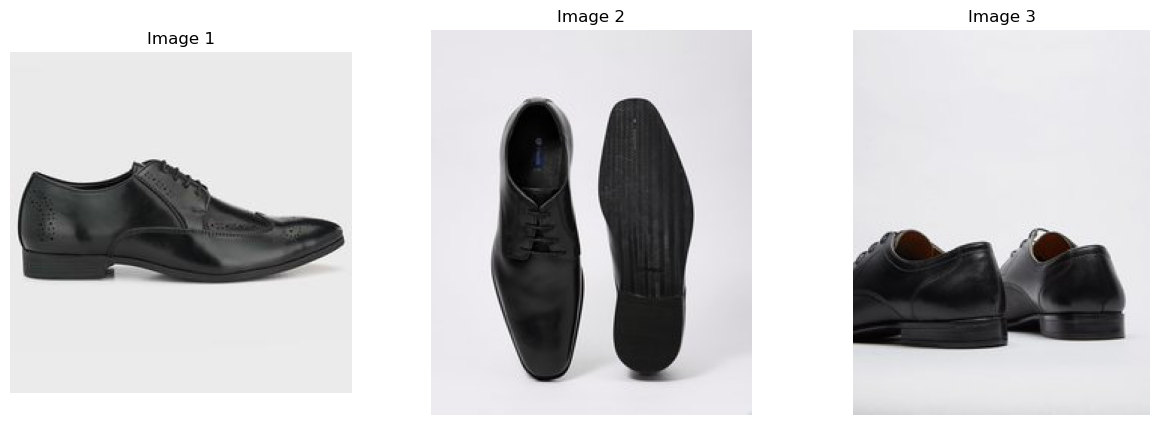

In [51]:
search("black leather shoes", 3)

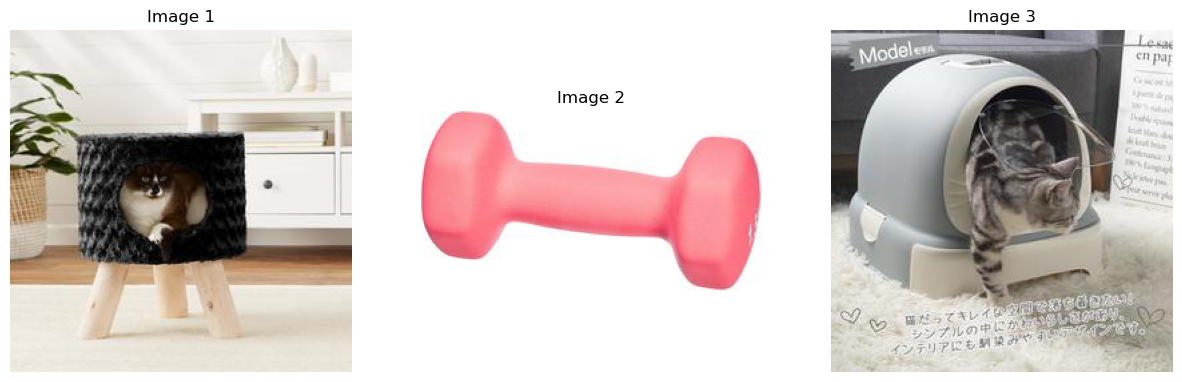

In [52]:
search("fluffy toy", 3)

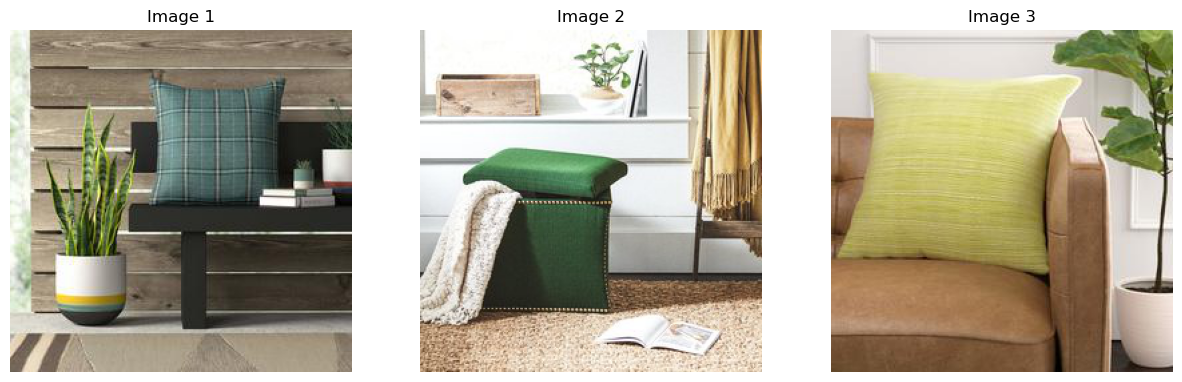

In [55]:
search("green living room accesories", 3)

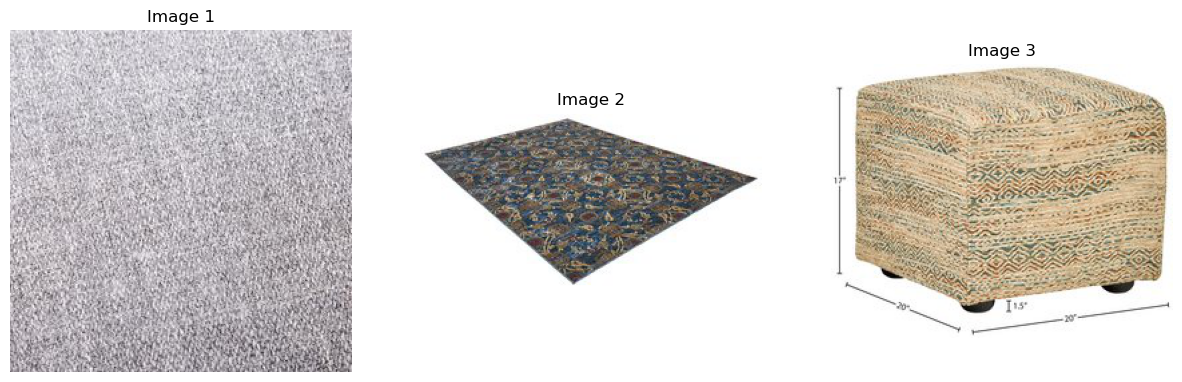

In [56]:
search("a carpet", 3)